In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.graphics.tsaplots import plot_acf
sys.path.append('..')
from src.model_utils import (prepare_data_for_modeling, build_arima_model,
                           build_sarima_model, evaluate_models, time_series_cv)
from src.oil_analysis_utils import load_and_process_data
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and prepare data
df = load_and_process_data('../data/BrentOilPrices.csv')
train, test = prepare_data_for_modeling(df)

Sample of dates before conversion:
0    20-May-87
1    21-May-87
2    22-May-87
3    25-May-87
4    26-May-87
Name: Date, dtype: object

Unique date formats in the dataset:
['20-May-87' '21-May-87' '22-May-87' '25-May-87' '26-May-87']
First attempt failed with error: time data "Apr 22, 2020" doesn't match format "%d-%b-%y", at position 8360. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


In [3]:
# Build models
arima_pred, arima_results = build_arima_model(train, test)
sarima_pred, sarima_results = build_sarima_model(train, test)

In [5]:
# Evaluate models
predictions_dict = {
    'ARIMA': arima_pred,
    'SARIMA': sarima_pred
}
evaluation_results = evaluate_models(test, predictions_dict)
print("\nModel Evaluation Results:")
display(evaluation_results)


Model Evaluation Results:


,RMSE,MAE,R2
ARIMA,25.474642,19.061386,-0.520779
SARIMA,22.575056,16.825512,-0.194284


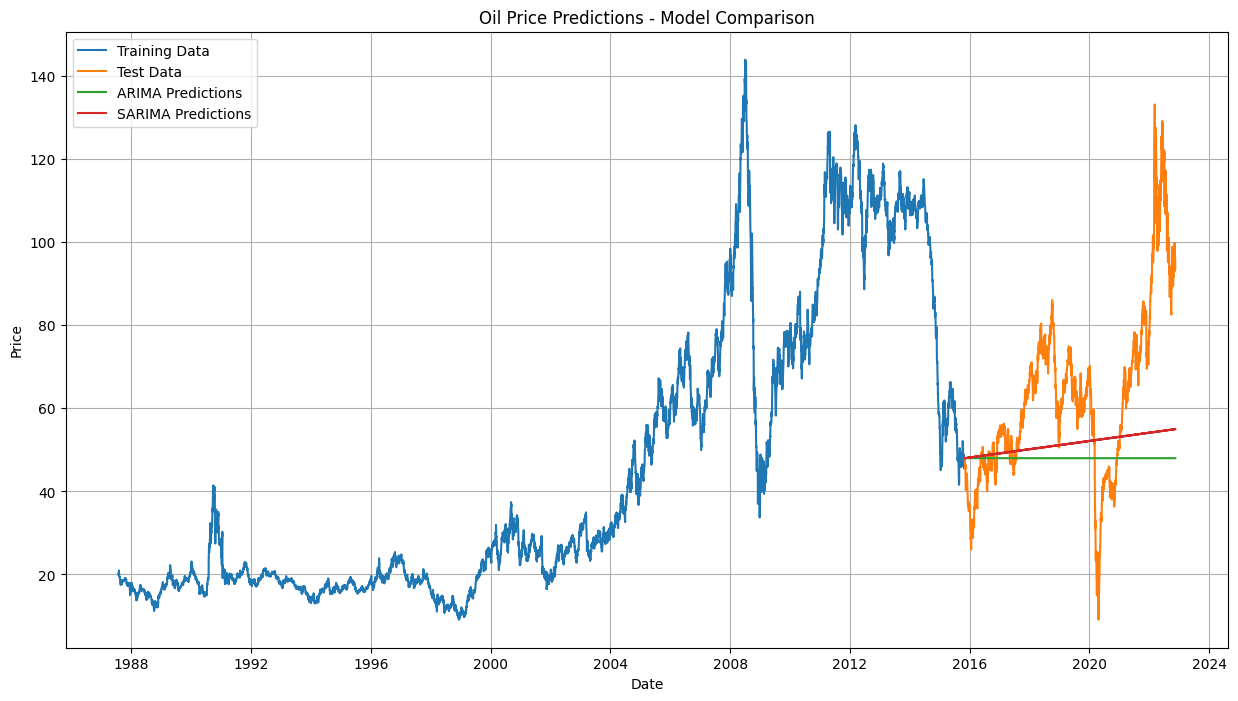

In [6]:
# Plot predictions
plt.figure(figsize=(15, 8))
plt.plot(train.index, train['Price'], label='Training Data')
plt.plot(test.index, test['Price'], label='Test Data')
plt.plot(test.index, arima_pred, label='ARIMA Predictions')
plt.plot(test.index, sarima_pred, label='SARIMA Predictions')
plt.title('Oil Price Predictions - Model Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

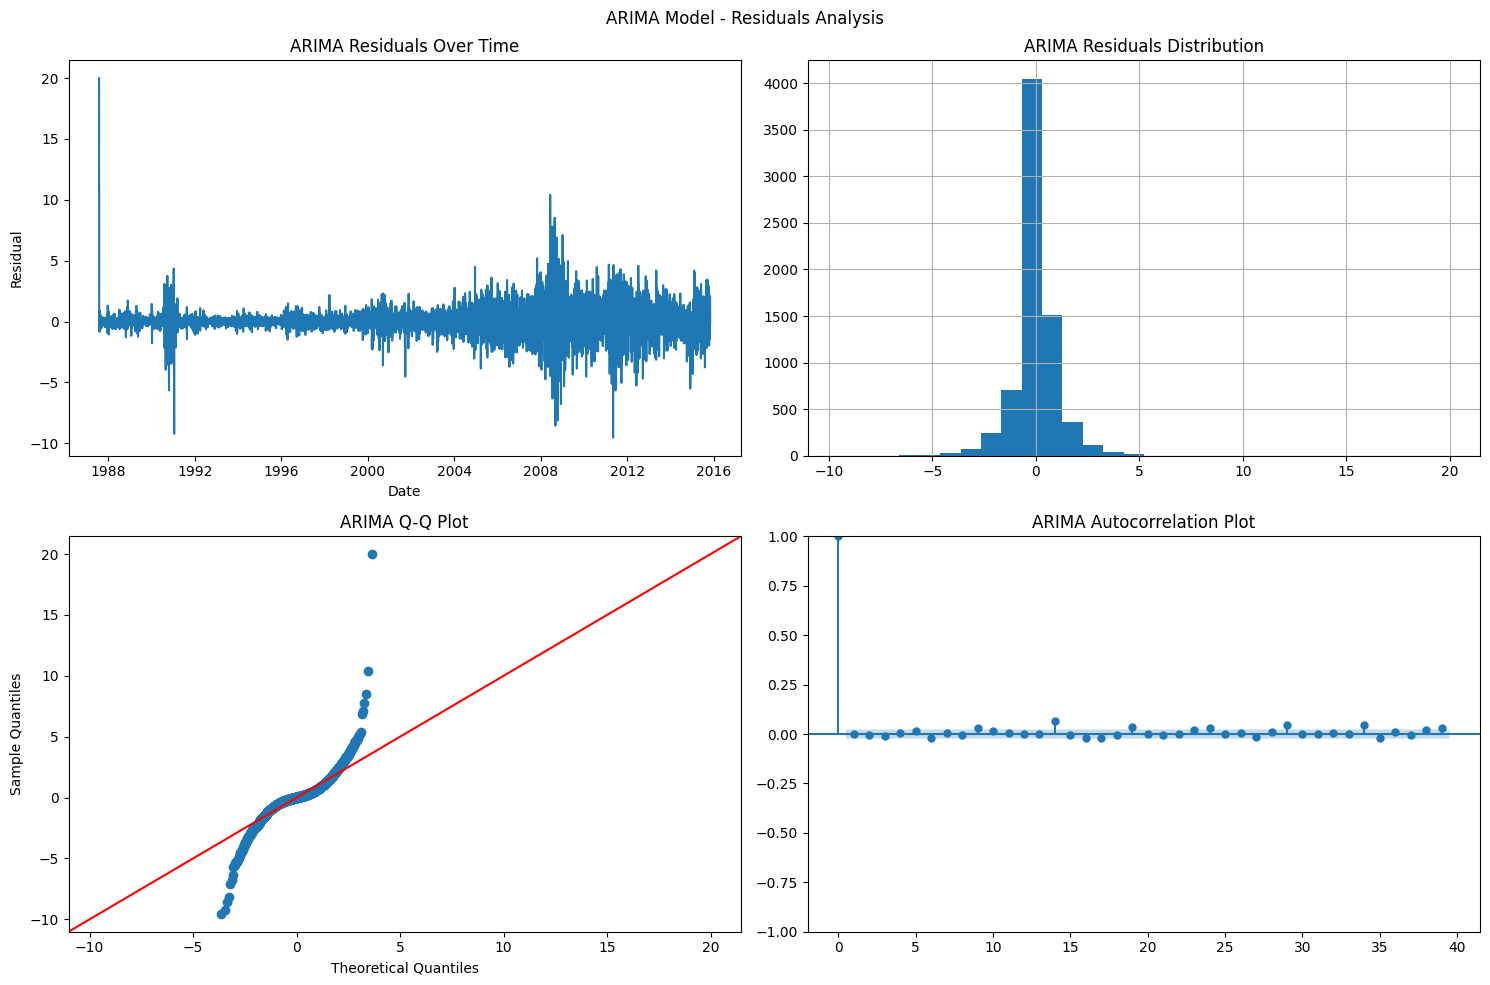

In [7]:
# Plot residuals analysis for ARIMA
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

residuals = arima_results.resid
ax1.plot(residuals)
ax1.set_title('ARIMA Residuals Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Residual')

residuals.hist(ax=ax2, bins=30)
ax2.set_title('ARIMA Residuals Distribution')

QQ = ProbPlot(residuals)
QQ.qqplot(line='45', ax=ax3)
ax3.set_title('ARIMA Q-Q Plot')

plot_acf(residuals, ax=ax4)
ax4.set_title('ARIMA Autocorrelation Plot')

plt.suptitle('ARIMA Model - Residuals Analysis')
plt.tight_layout()
plt.show()


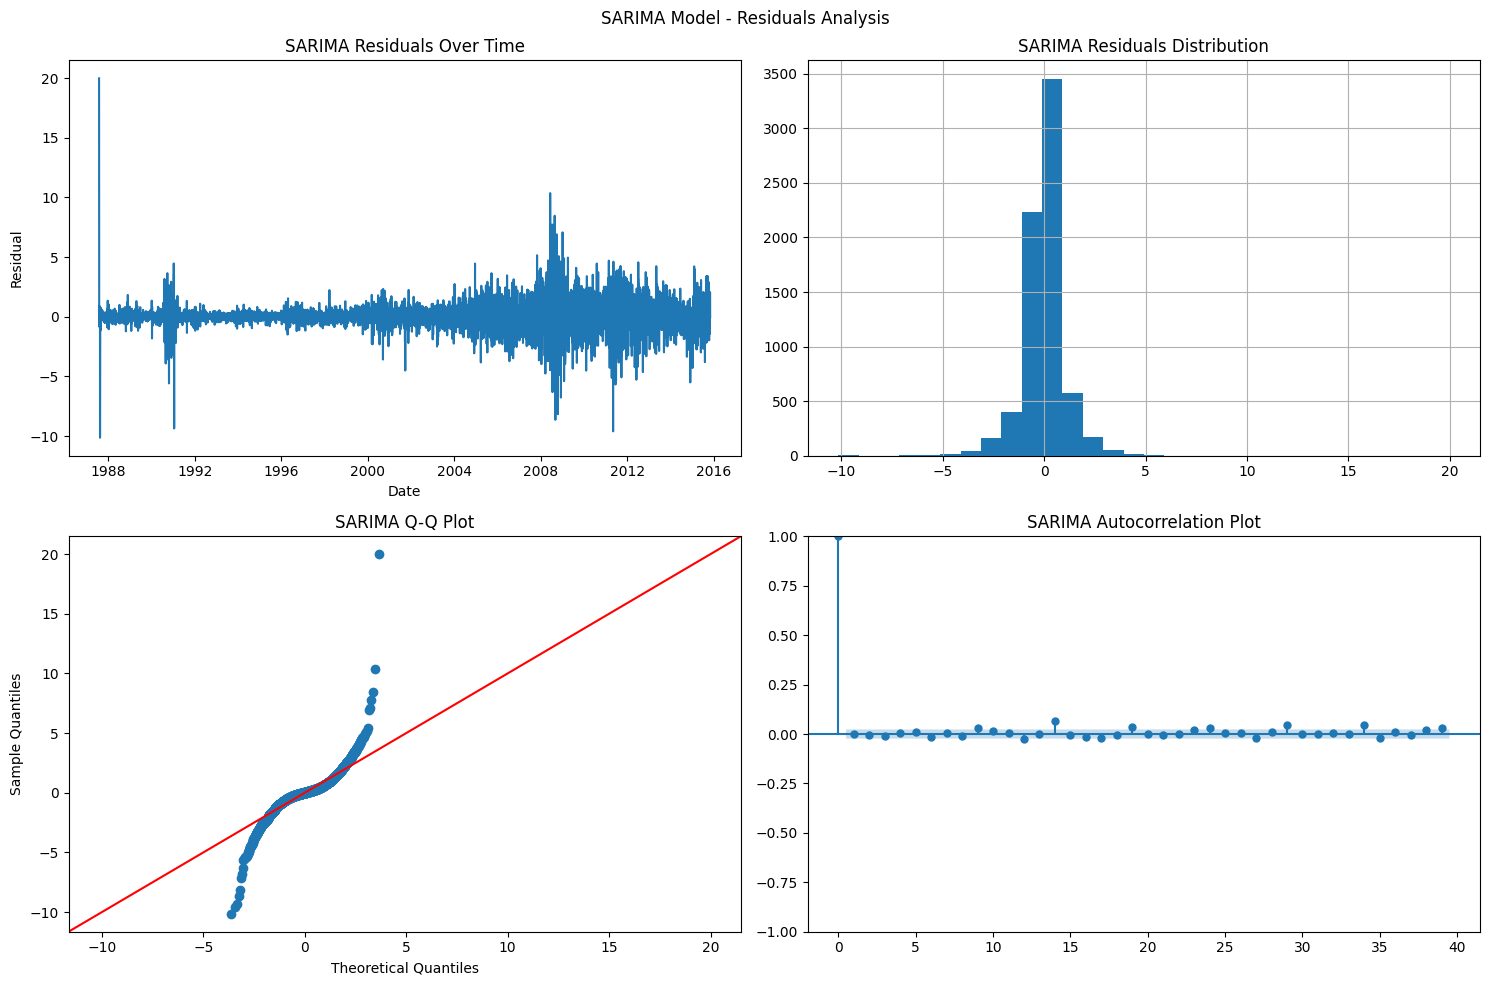

In [8]:
# Plot residuals analysis for SARIMA
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

residuals = sarima_results.resid
ax1.plot(residuals)
ax1.set_title('SARIMA Residuals Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Residual')

residuals.hist(ax=ax2, bins=30)
ax2.set_title('SARIMA Residuals Distribution')

QQ = ProbPlot(residuals)
QQ.qqplot(line='45', ax=ax3)
ax3.set_title('SARIMA Q-Q Plot')

plot_acf(residuals, ax=ax4)
ax4.set_title('SARIMA Autocorrelation Plot')

plt.suptitle('SARIMA Model - Residuals Analysis')
plt.tight_layout()
plt.show()

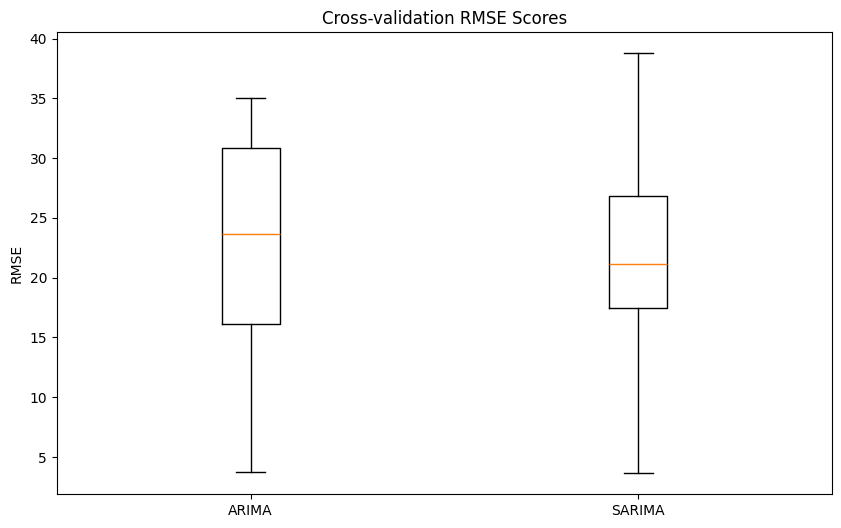

In [9]:
# Perform cross-validation and plot results
cv_results = time_series_cv(df)

plt.figure(figsize=(10, 6))
plt.boxplot([cv_results['ARIMA'], cv_results['SARIMA']], labels=['ARIMA', 'SARIMA'])
plt.title('Cross-validation RMSE Scores')
plt.ylabel('RMSE')
plt.show()